<a href="https://colab.research.google.com/github/ViniTelheiro/Curso_RNN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers



#Loading and pre-processing the dataset:

In [2]:
(x_train, y_train), (_,_) = tf.keras.datasets.mnist.load_data()
x_train[0].min(), x_train[0].max()


(0, 255)

In [3]:
x_train = x_train.reshape(x_train.shape[0], 28,28,1).astype('float32')

#normalize between -1 and 1
x_train = (x_train - 127.5)/127.5

x_train[0].min(), x_train[0].max()

(-1.0, 1.0)

In [4]:
buffer_size = x_train.shape[0]
batch_size = 256
buffer_size/batch_size

234.375

In [5]:
type(x_train)

numpy.ndarray

In [6]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [7]:
x_train

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

#Building the Generator:

In [8]:
def create_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  network.add(layers.Conv2DTranspose(filters=128, kernel_size=(5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Conv2DTranspose(filters=64, kernel_size=(5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  
  network.add(layers.Conv2DTranspose(filters=1, kernel_size=(5,5), use_bias=False, strides=(2,2), padding='same', activation='tanh'))
  
  network.summary()

  return network


In [9]:
generator = create_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [10]:
ruido = tf.random.normal([1,100])


In [11]:
imagem_gerada = generator(ruido, training=False)

In [12]:
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

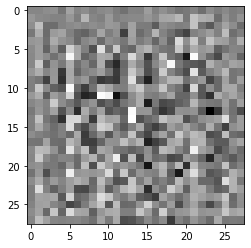

In [13]:
plt.imshow(imagem_gerada[0,:,:,0], cmap='gray')

#Build Discriminator:

In [14]:
def create_discriminator():
  network = tf.keras.Sequential()
  
  network.add(layers.Conv2D(filters=64, strides=(2,2), kernel_size=(5,5), padding='same', input_shape=(28,28,1)))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(.3))

  network.add(layers.Conv2D(filters=128, strides=(2,2), kernel_size=(5,5), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(.3))

  network.add(layers.Flatten())

  network.add(layers.Dense(1, activation='sigmoid'))

  network.summary()
  return network


In [15]:
discriminator = create_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [16]:
discriminator(imagem_gerada, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49932986]], dtype=float32)>

#Calculo de erro:
(Real images label = 1; fake image label=0)

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [18]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss
  
  return total_loss

In [19]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
generator_optimizier = tf.keras.optimizers.Adam(learning_rate=1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

#Training the model and visualize results:

In [21]:
epochs = 100
noise_dim = 100
image_number = 16

In [22]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #um gradiente para o discriminador e outro para o gerador
    generated_image = generator(noise, training=True)
    
    expected_output = discriminator(images, training=True)
    fake_output = discriminator(generated_image, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output=expected_output, fake_output=fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizier.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))



In [23]:
test_images = tf.random.normal((image_number, noise_dim))
test_images.shape

TensorShape([16, 100])

In [28]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    for batch_image in dataset:
      train(batch_image)
    
    print(f'Epoch: {epoch+1}')
    generated_images = generator(test_images, training=False)
    fig = plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i,:,:,0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()


Epoch: 1


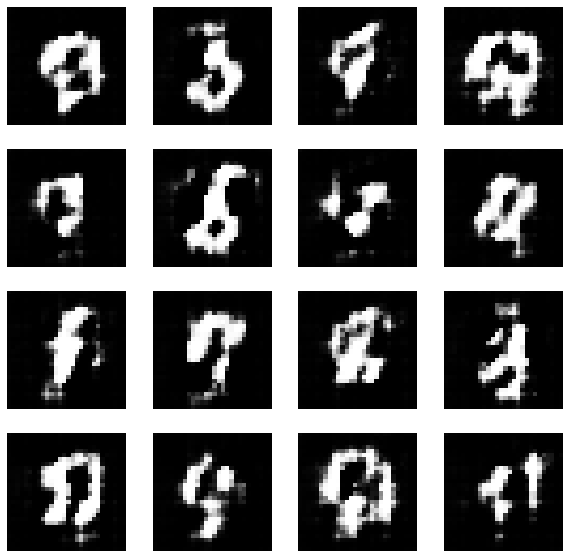

Epoch: 2


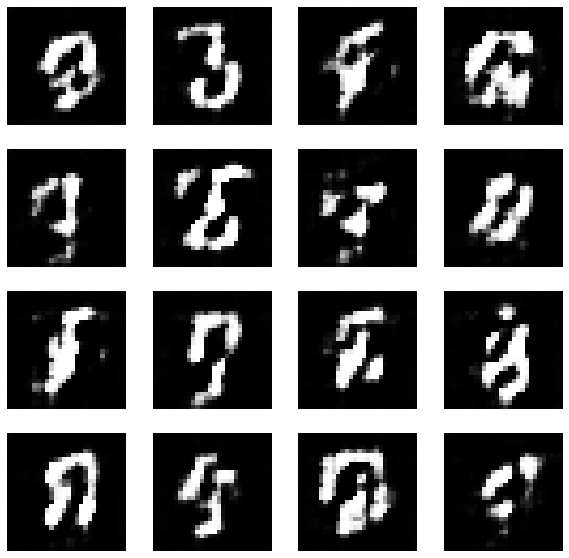

Epoch: 3


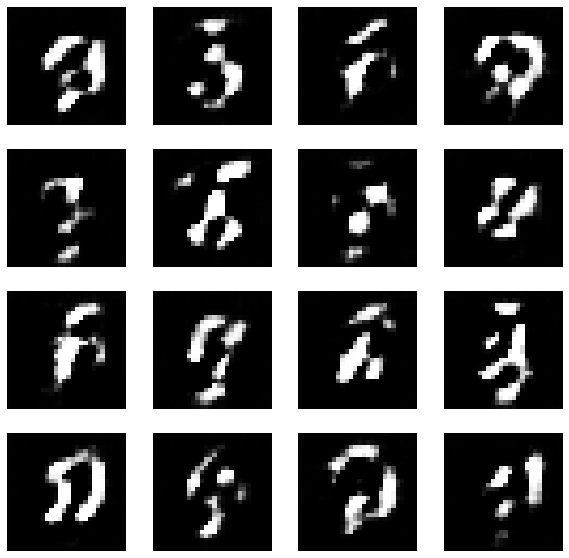

Epoch: 4


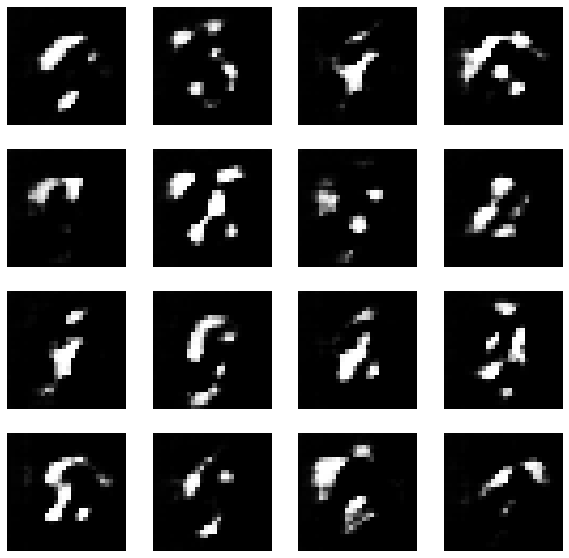

Epoch: 5


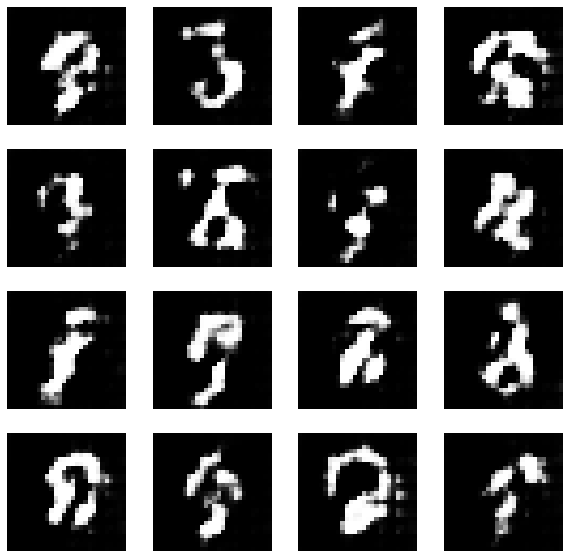

Epoch: 6


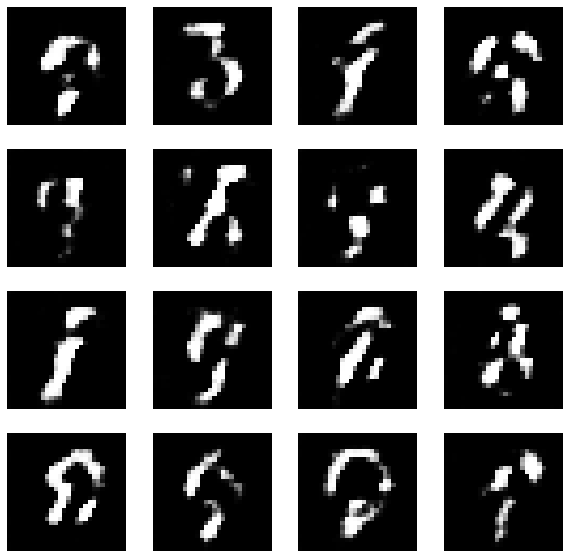

Epoch: 7


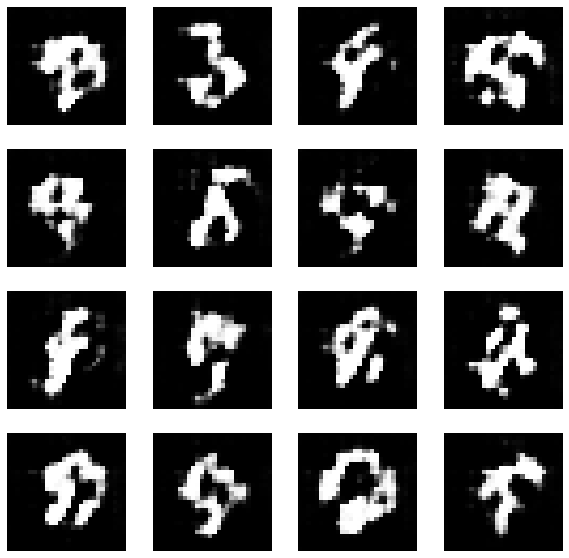

Epoch: 8


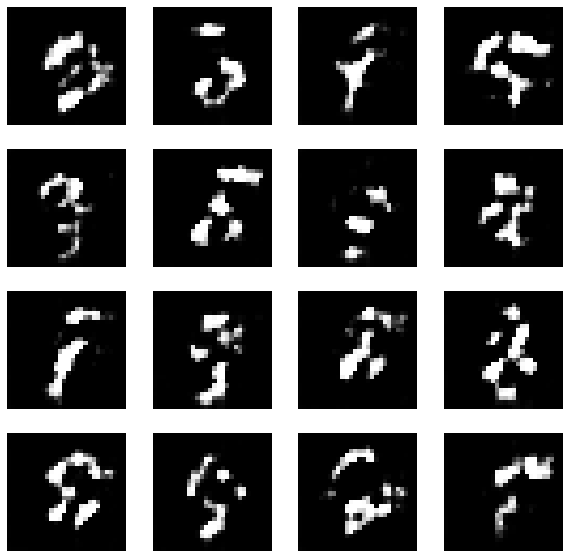

Epoch: 9


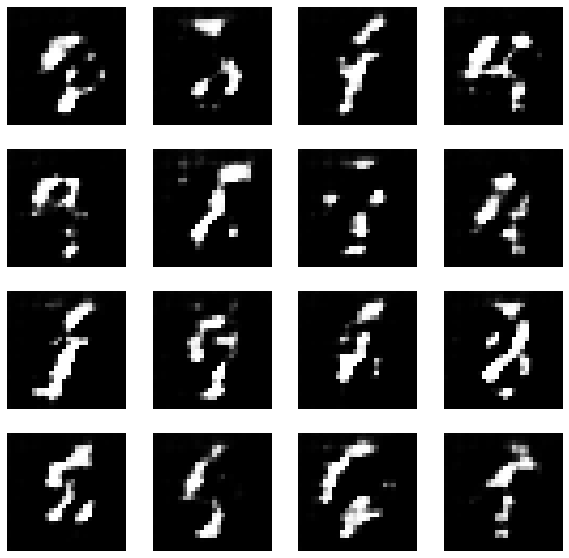

Epoch: 10


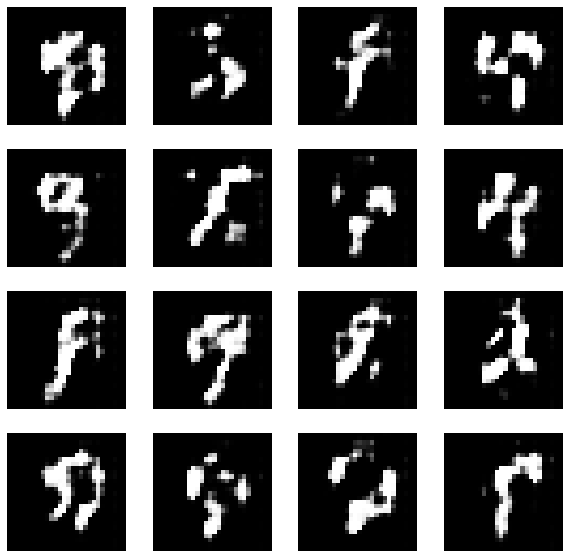

Epoch: 11


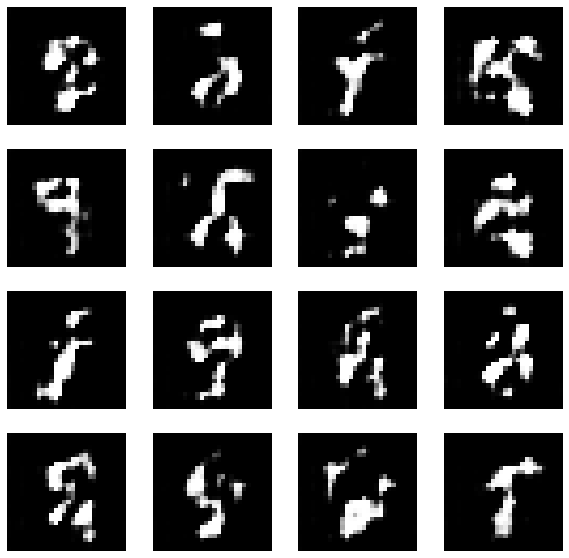

Epoch: 12


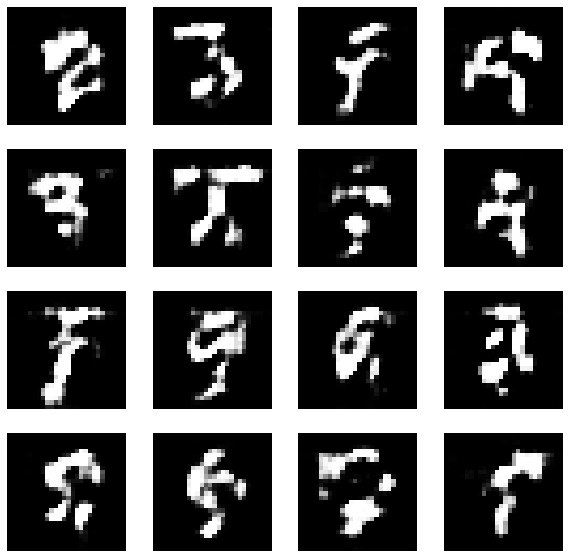

Epoch: 13


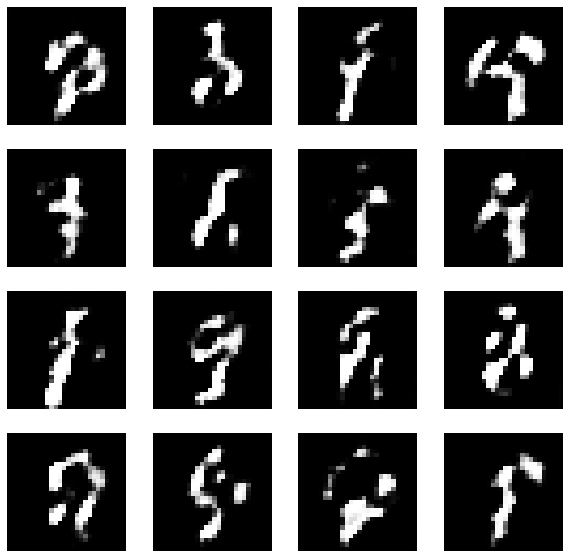

Epoch: 14


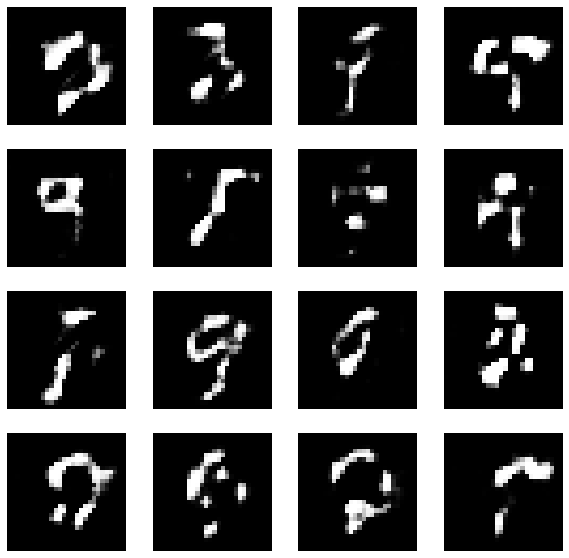

Epoch: 15


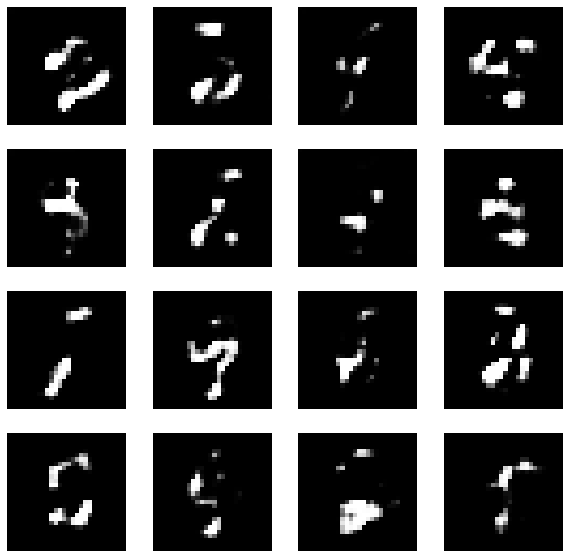

Epoch: 16


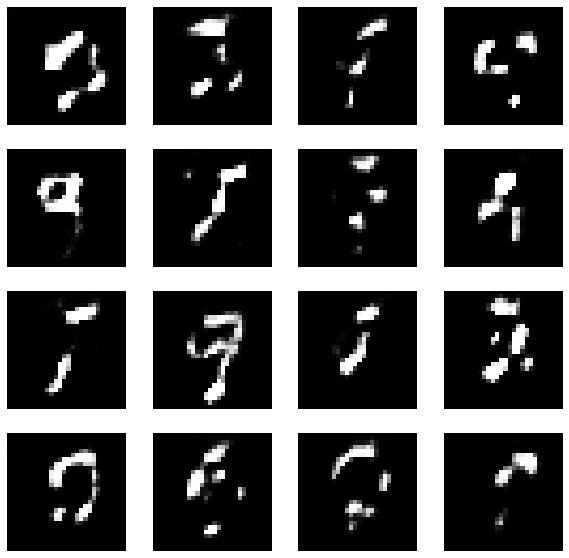

Epoch: 17


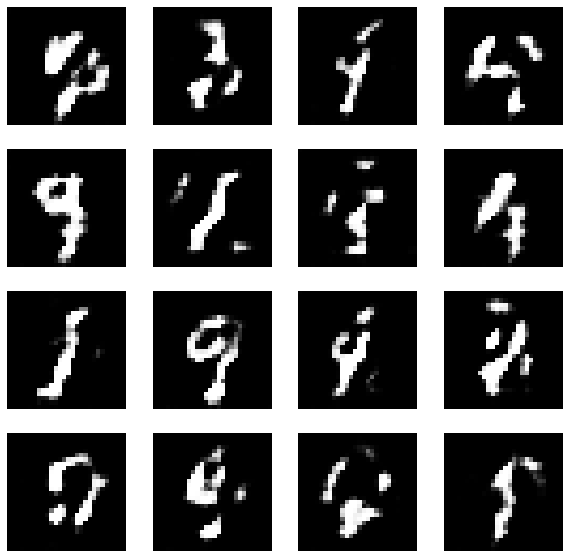

Epoch: 18


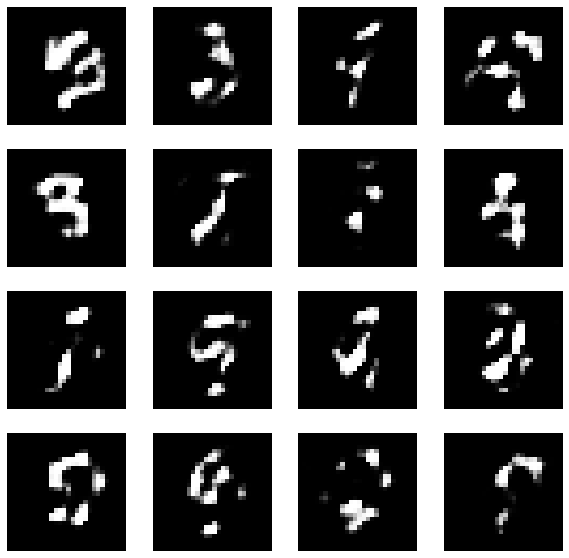

Epoch: 19


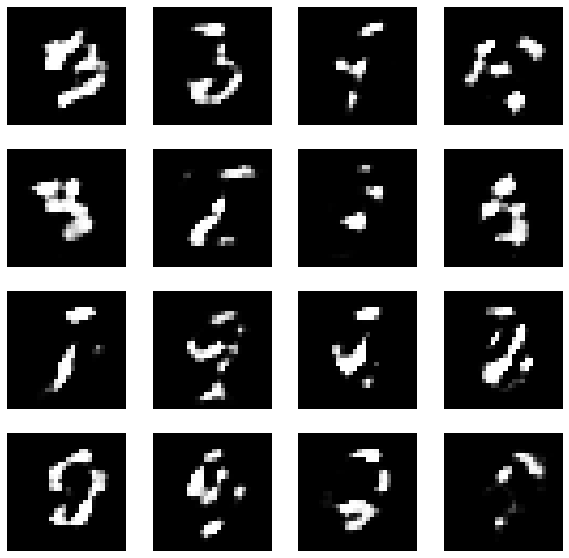

Epoch: 20


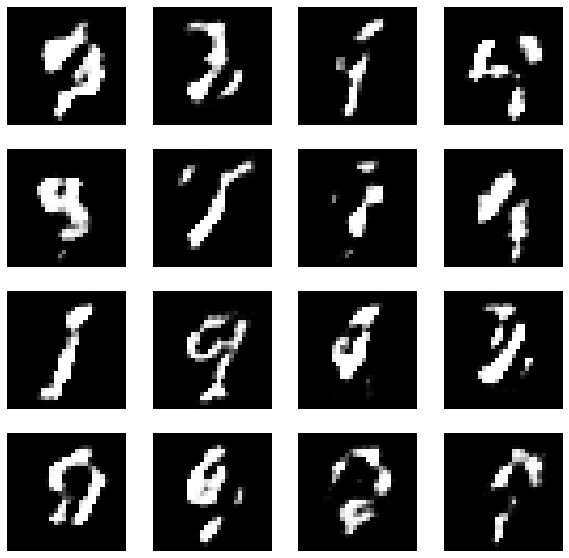

Epoch: 21


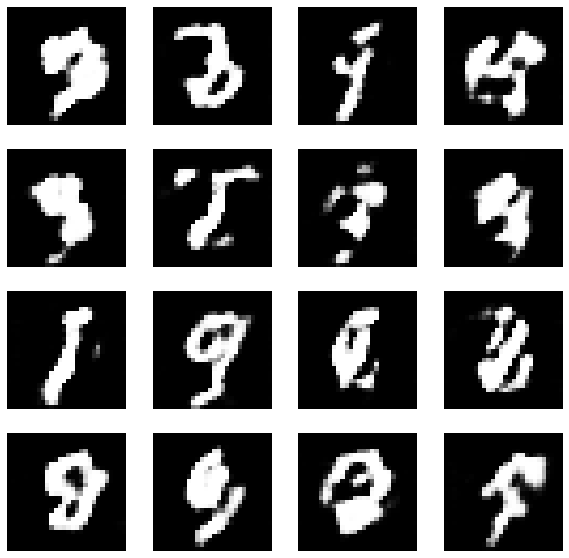

Epoch: 22


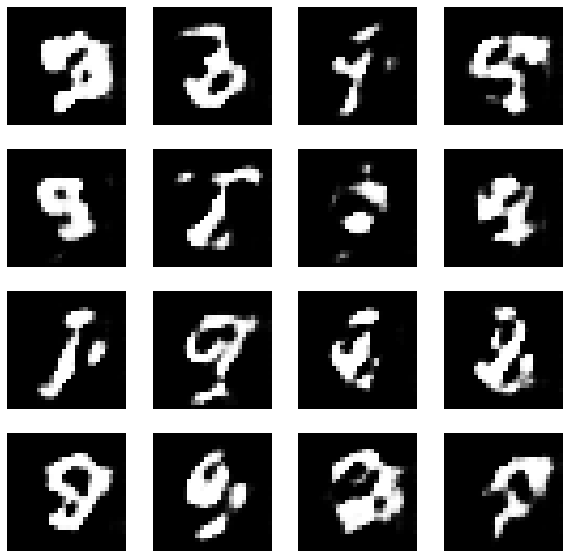

Epoch: 23


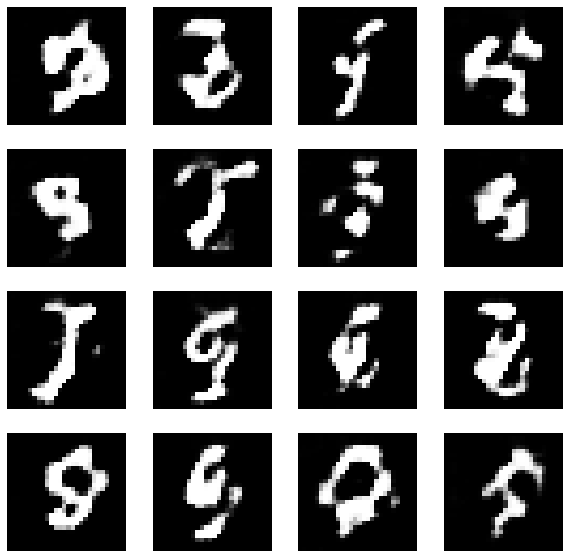

Epoch: 24


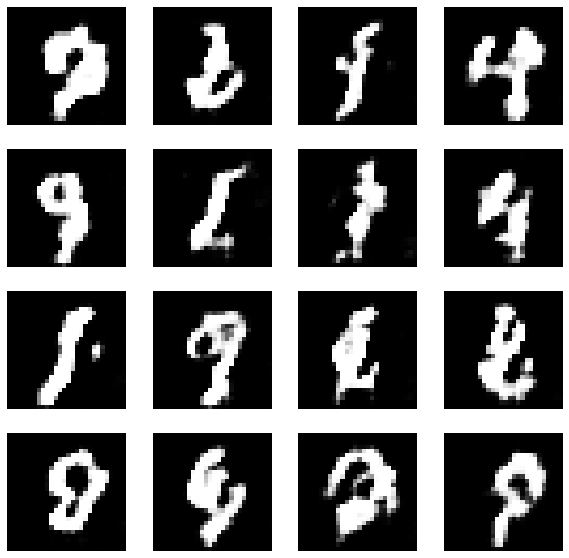

Epoch: 25


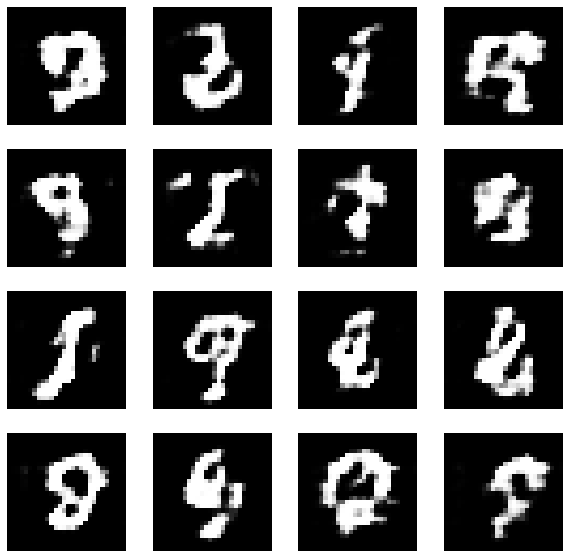

Epoch: 26


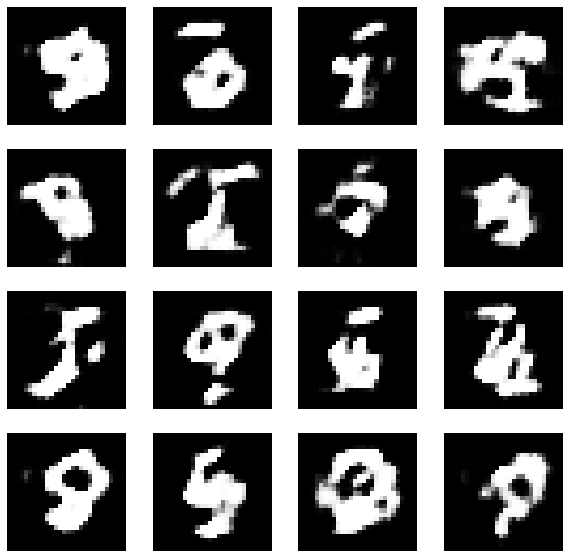

Epoch: 27


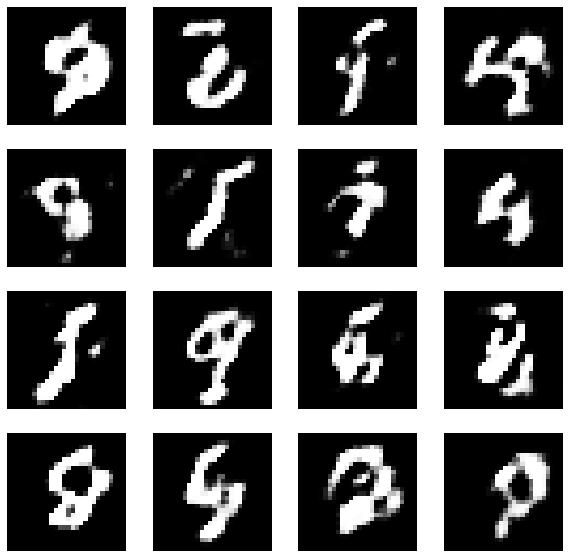

Epoch: 28


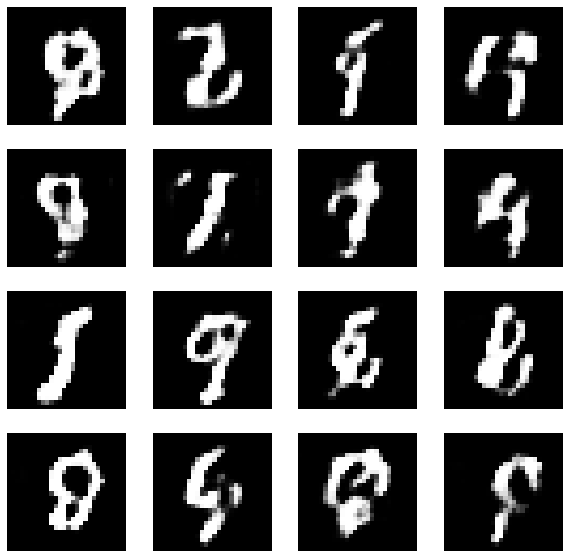

Epoch: 29


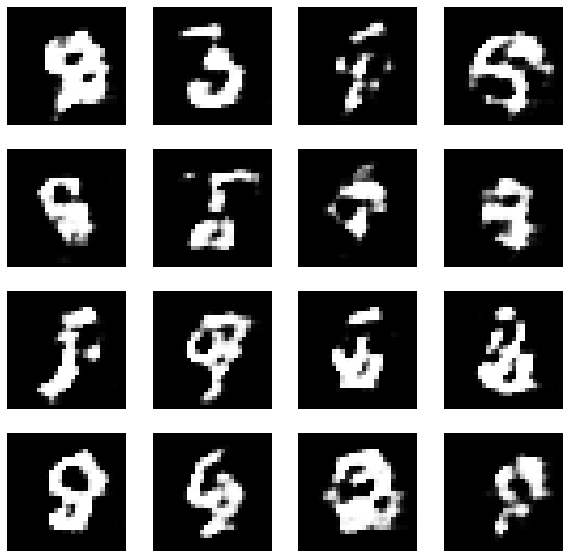

Epoch: 30


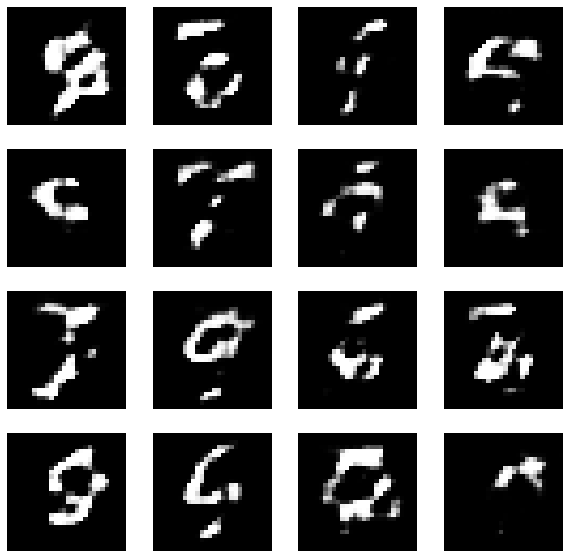

Epoch: 31


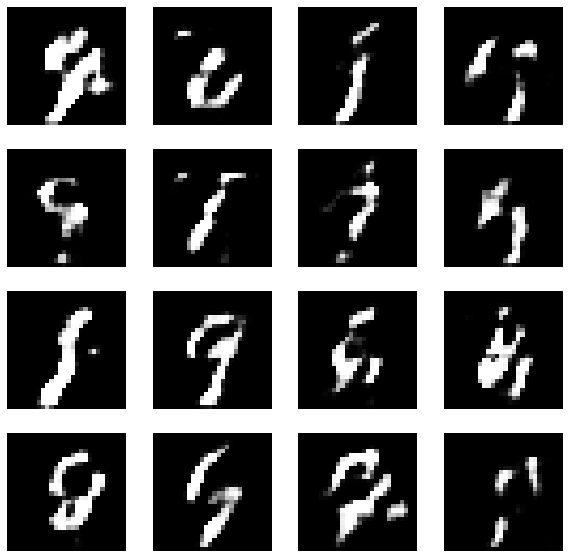

Epoch: 32


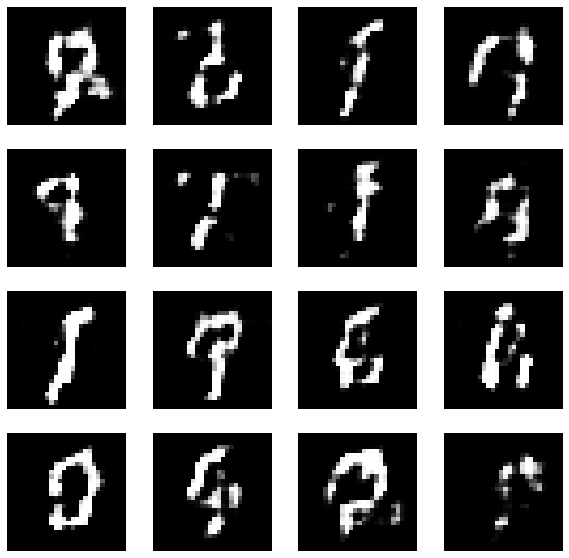

Epoch: 33


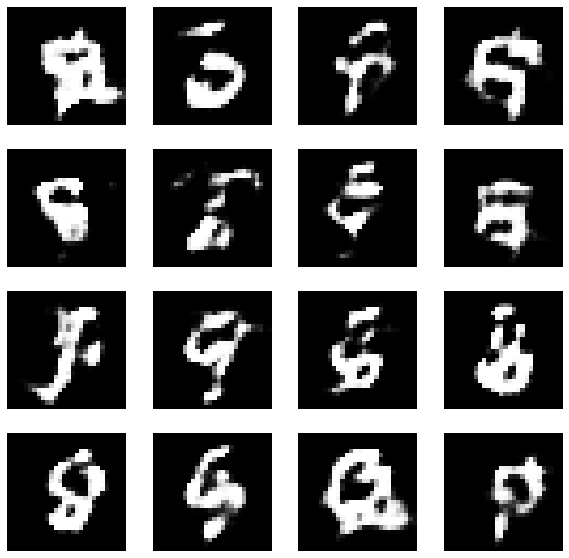

Epoch: 34


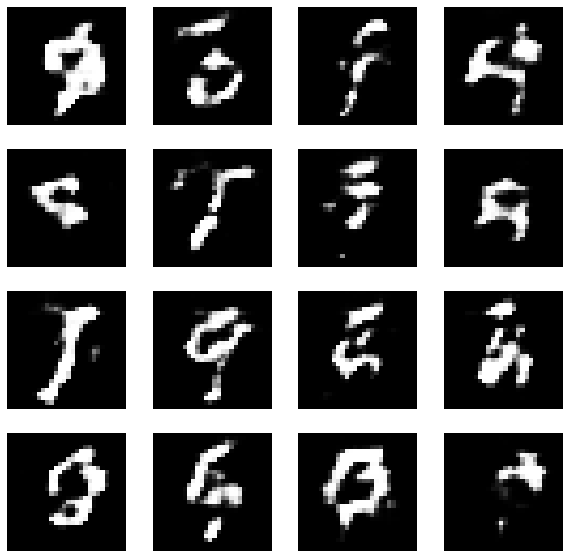

Epoch: 35


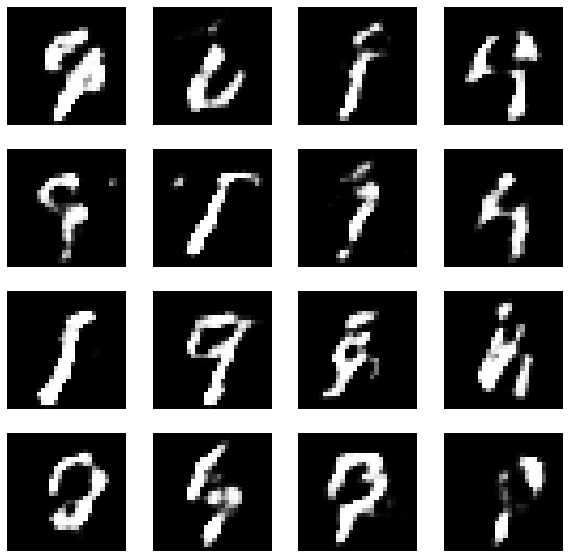

Epoch: 36


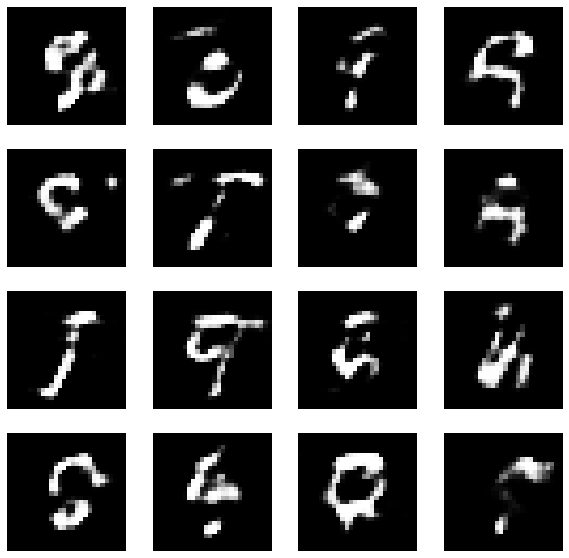

Epoch: 37


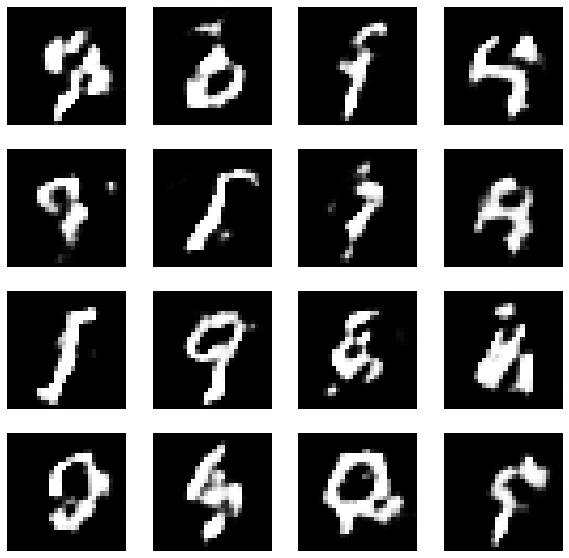

Epoch: 38


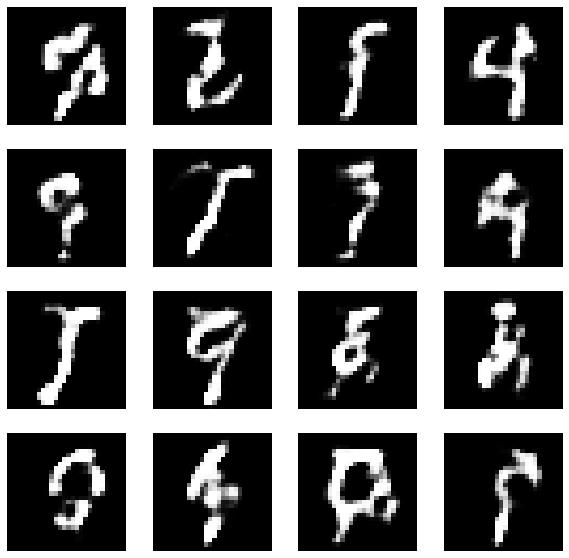

Epoch: 39


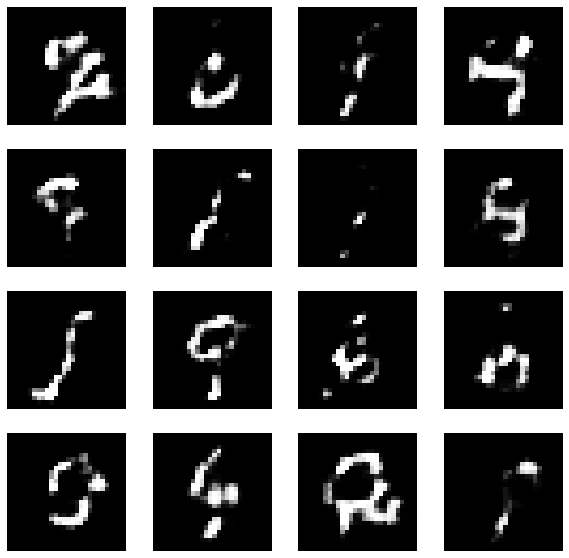

Epoch: 40


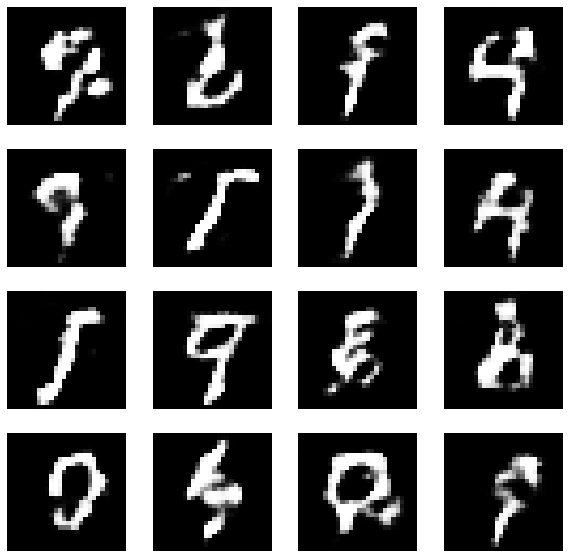

Epoch: 41


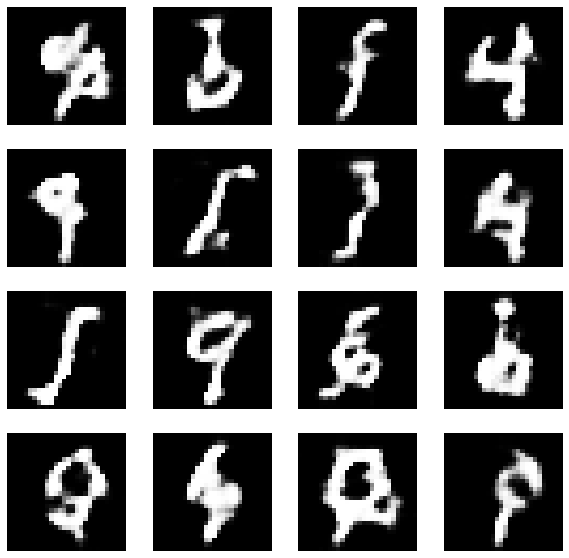

Epoch: 42


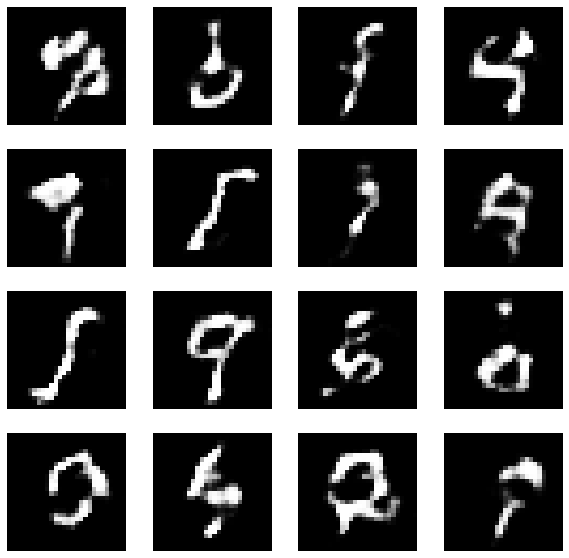

Epoch: 43


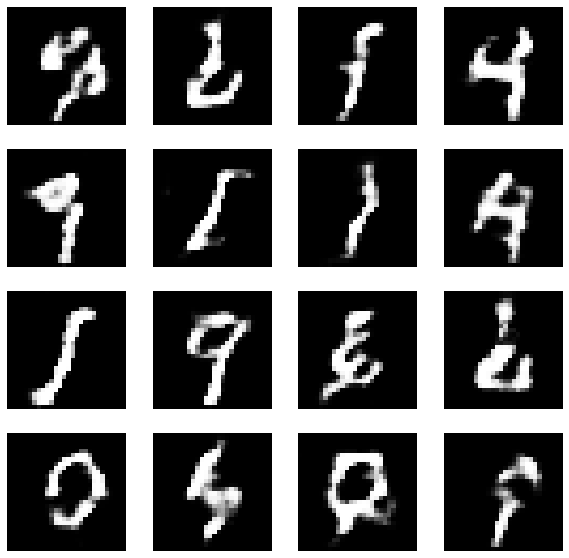

Epoch: 44


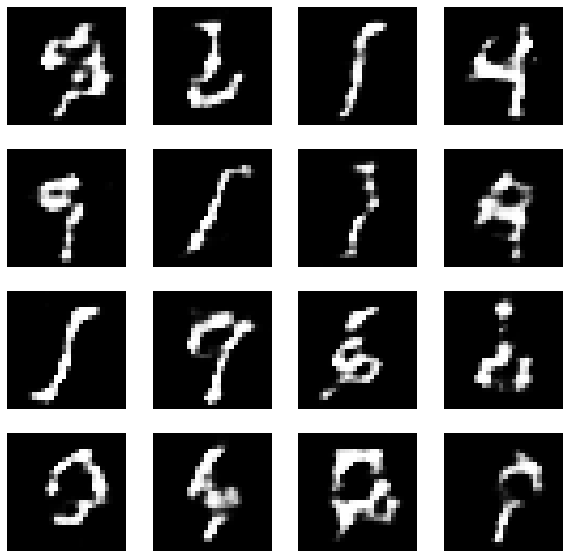

Epoch: 45


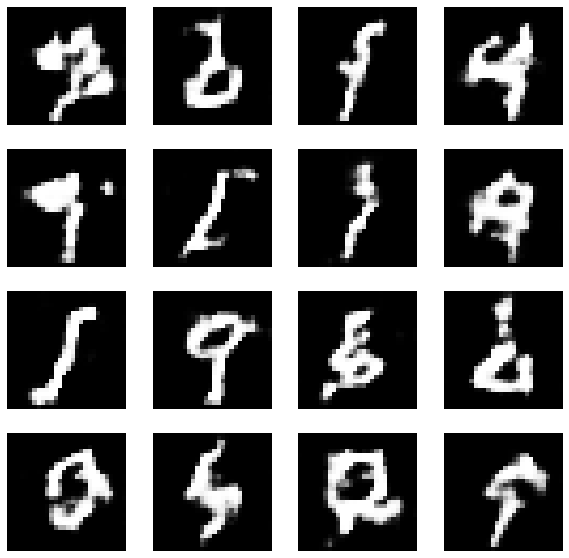

Epoch: 46


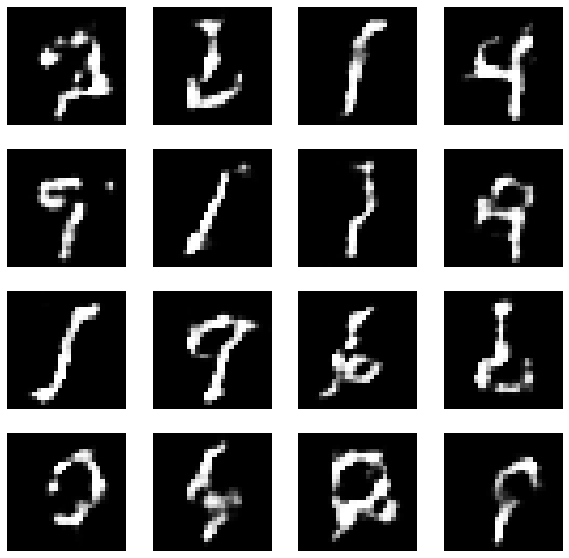

Epoch: 47


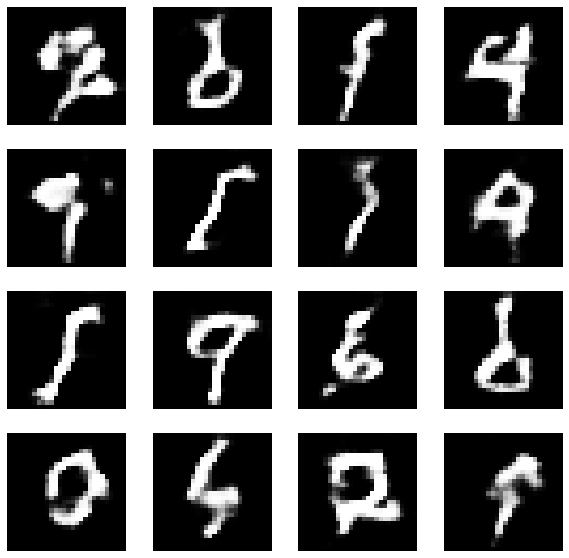

Epoch: 48


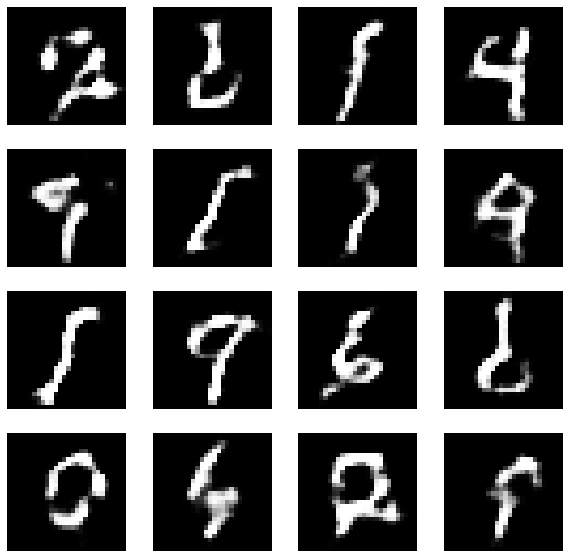

Epoch: 49


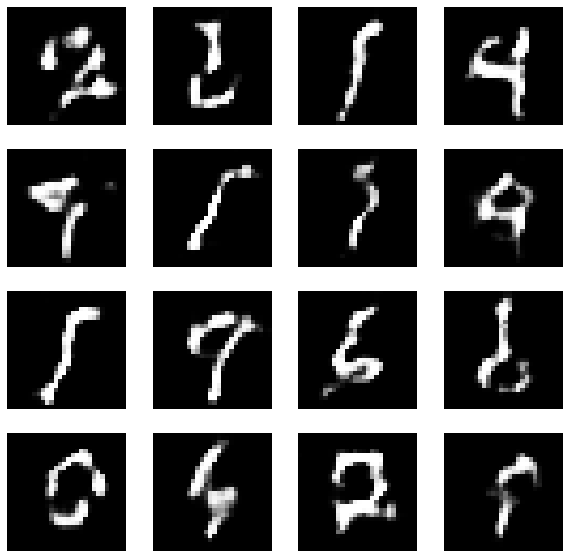

Epoch: 50


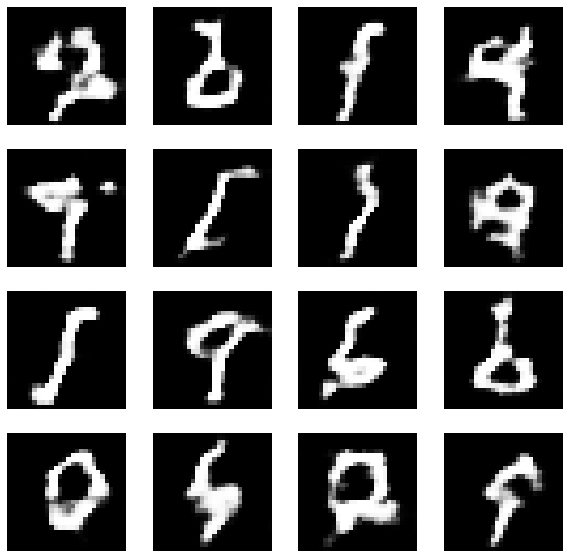

Epoch: 51


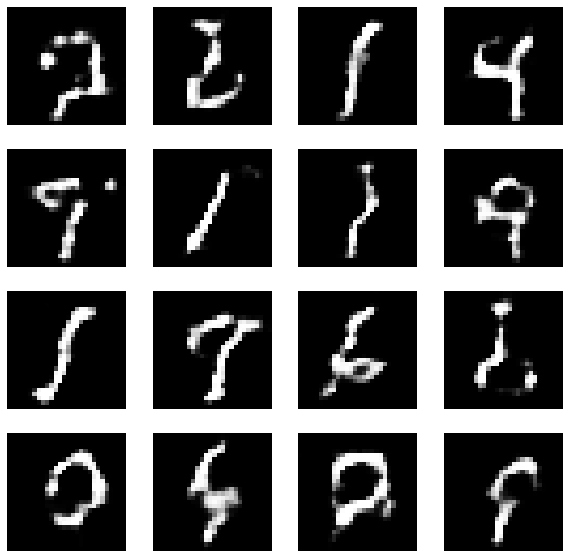

Epoch: 52


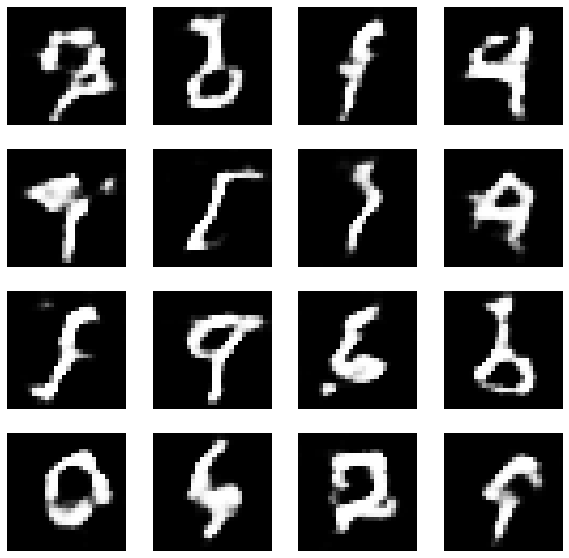

Epoch: 53


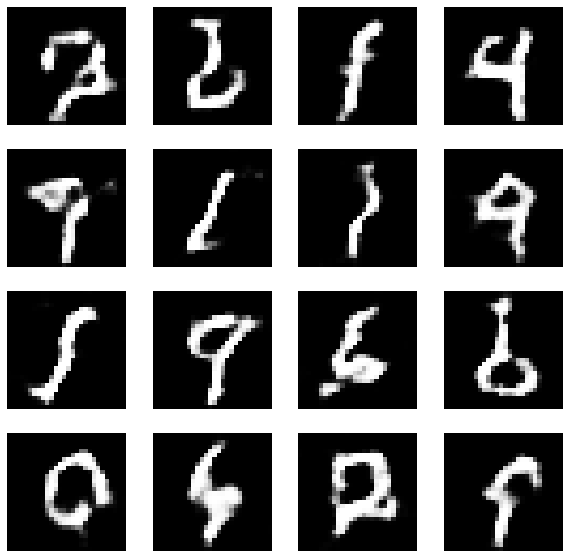

Epoch: 54


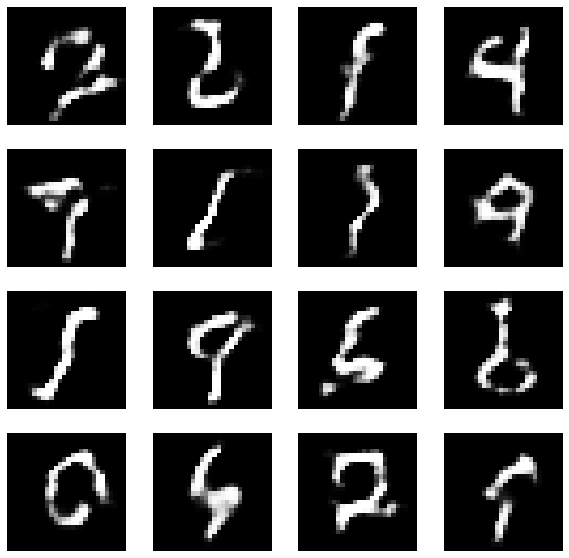

Epoch: 55


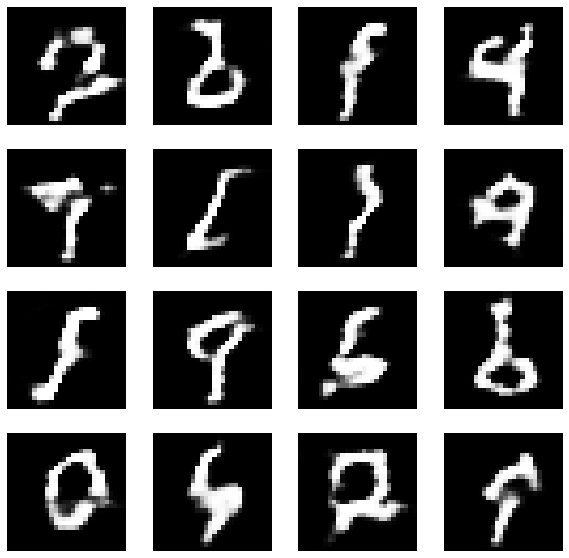

Epoch: 56


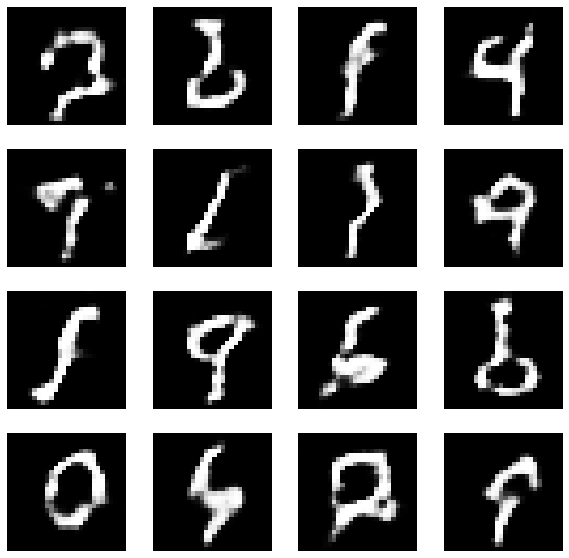

Epoch: 57


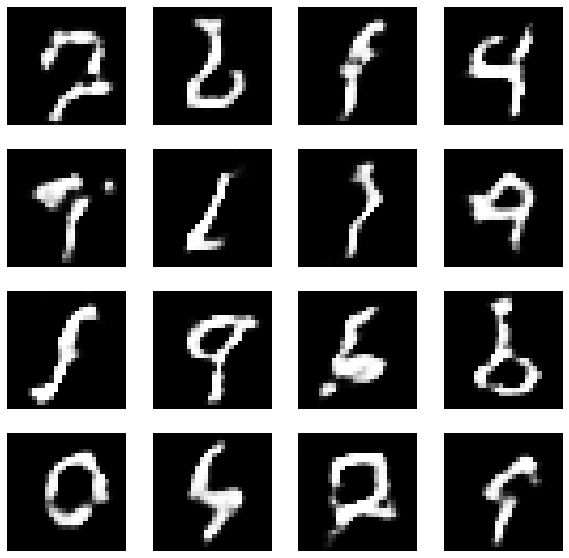

Epoch: 58


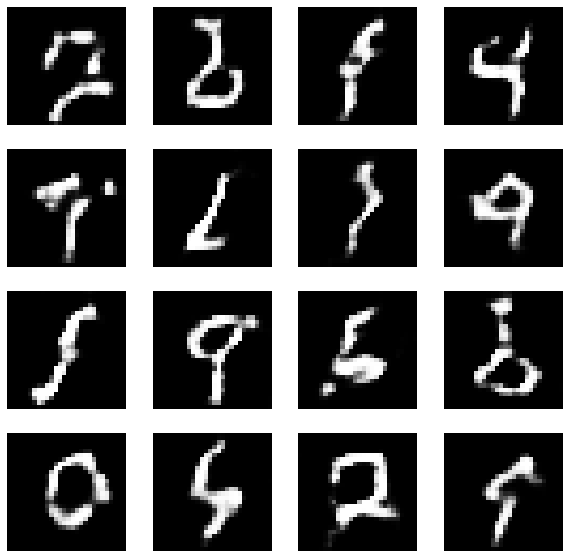

Epoch: 59


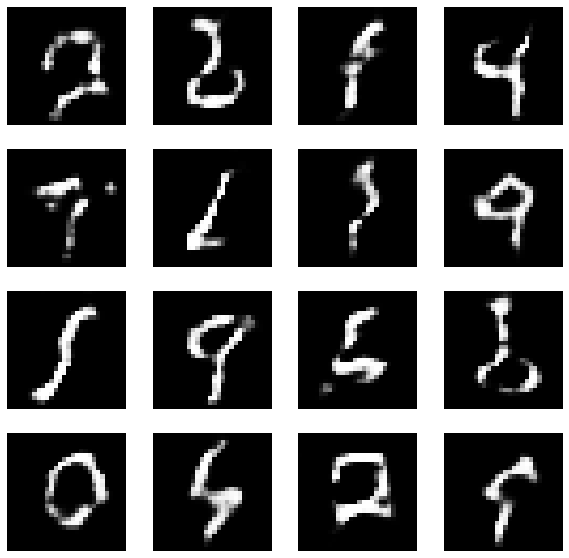

Epoch: 60


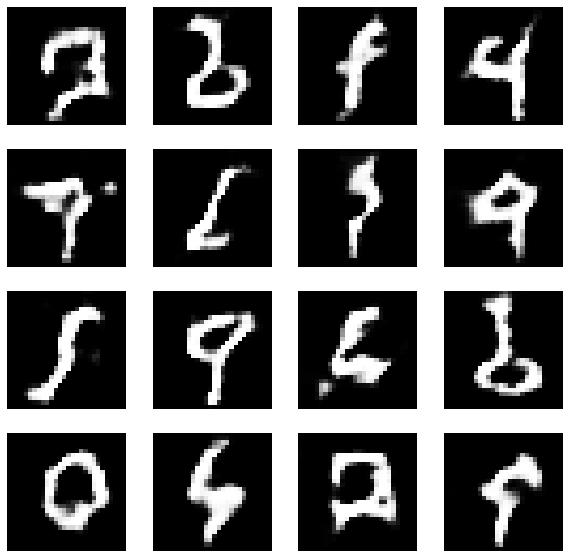

Epoch: 61


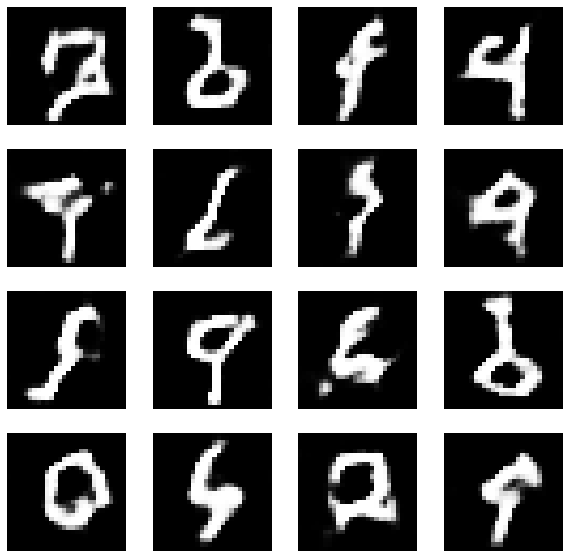

Epoch: 62


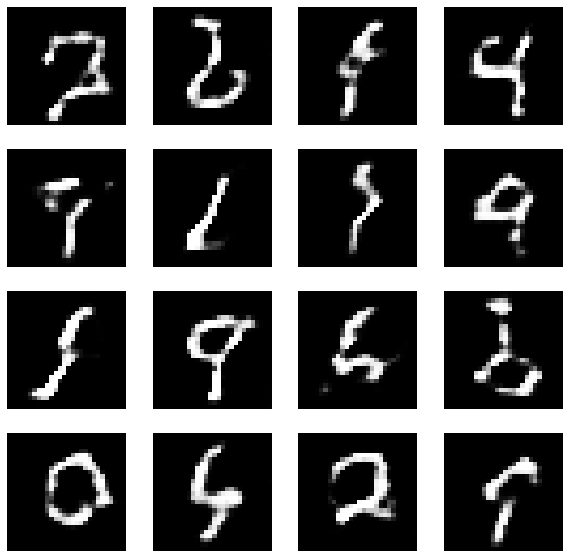

Epoch: 63


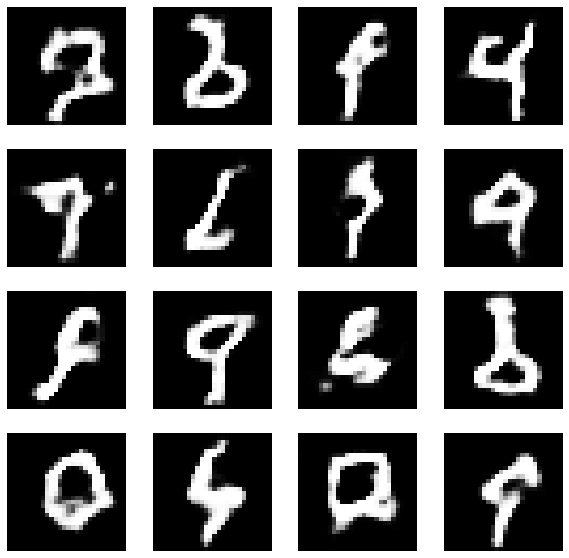

Epoch: 64


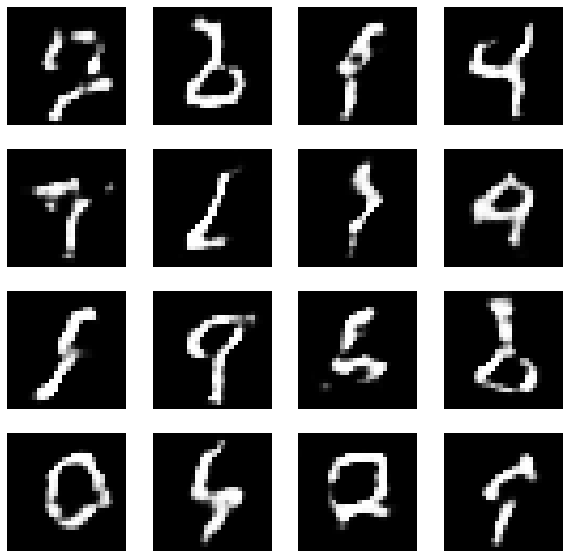

Epoch: 65


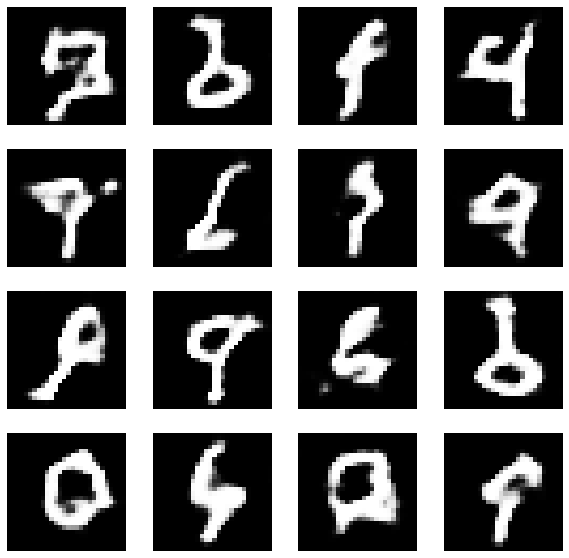

Epoch: 66


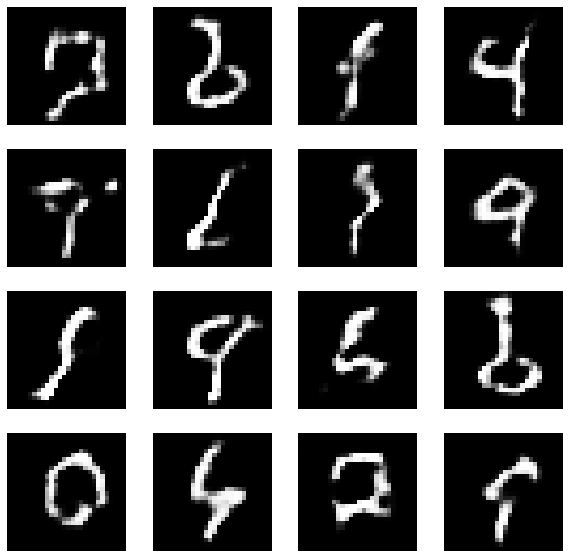

Epoch: 67


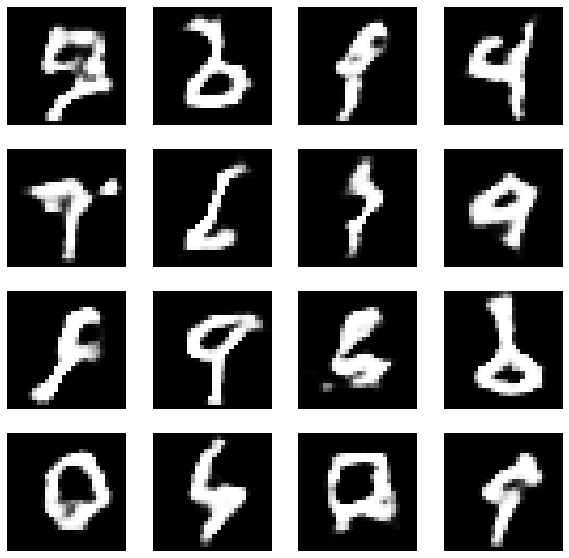

Epoch: 68


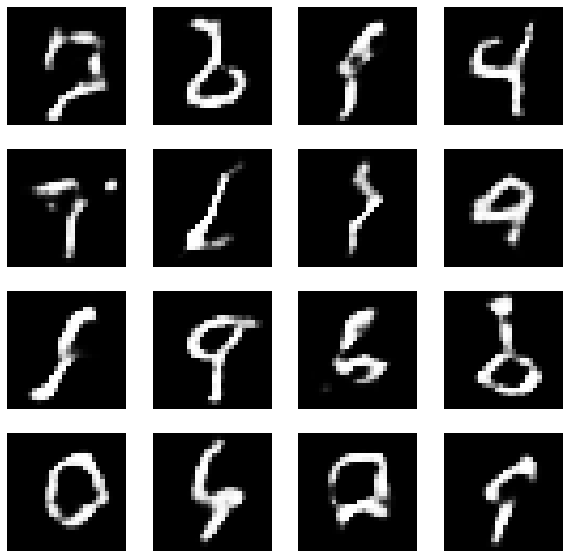

Epoch: 69


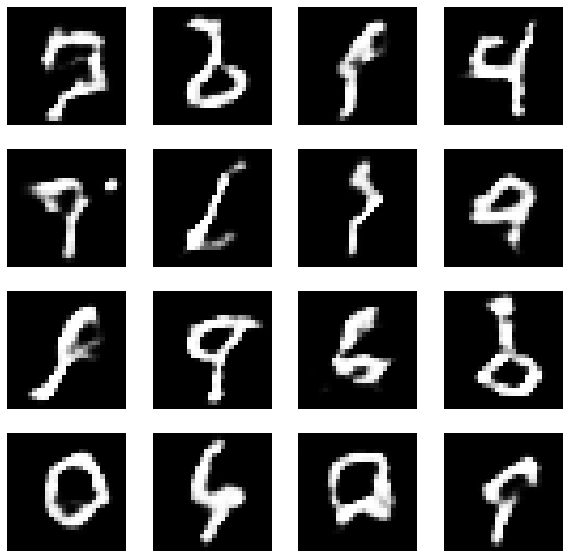

Epoch: 70


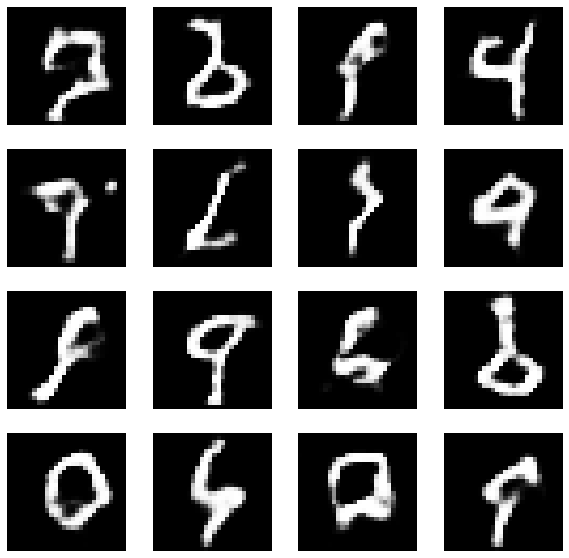

Epoch: 71


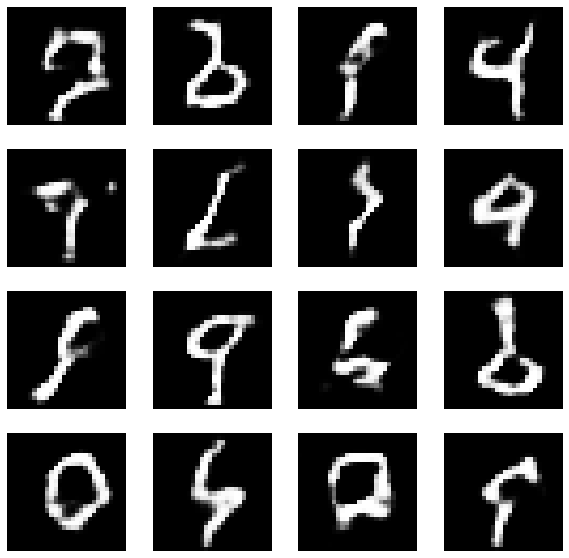

Epoch: 72


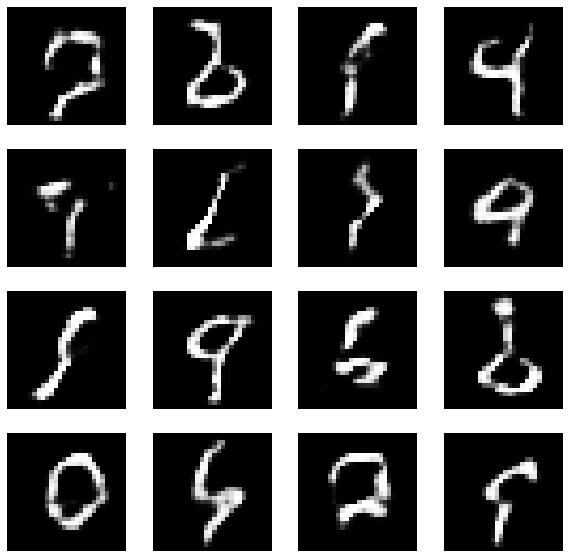

Epoch: 73


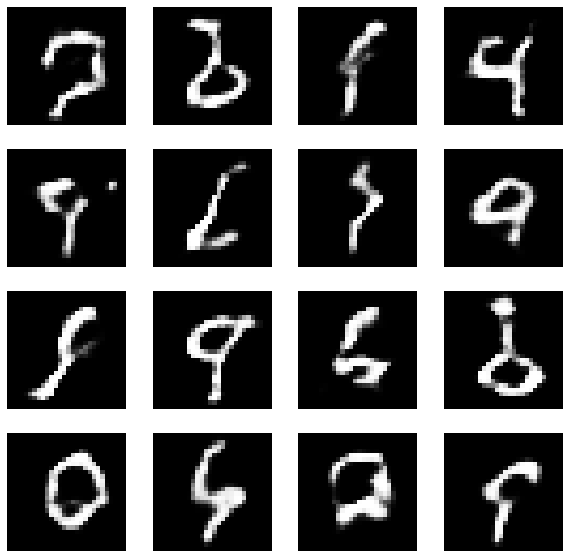

Epoch: 74


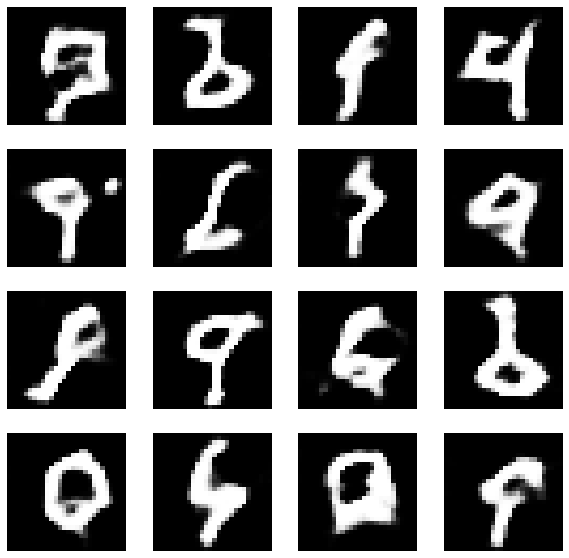

Epoch: 75


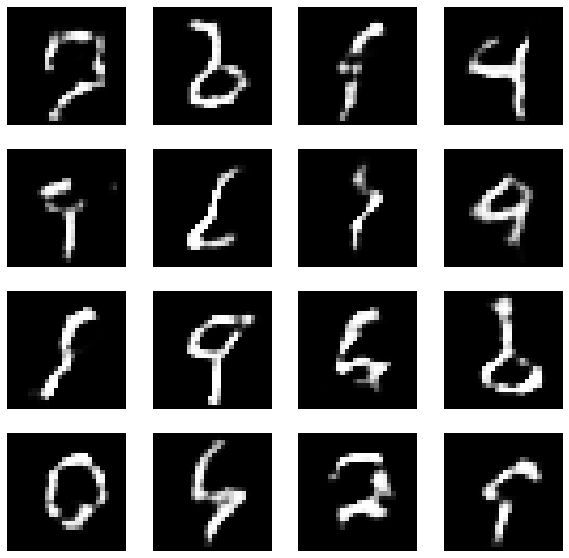

Epoch: 76


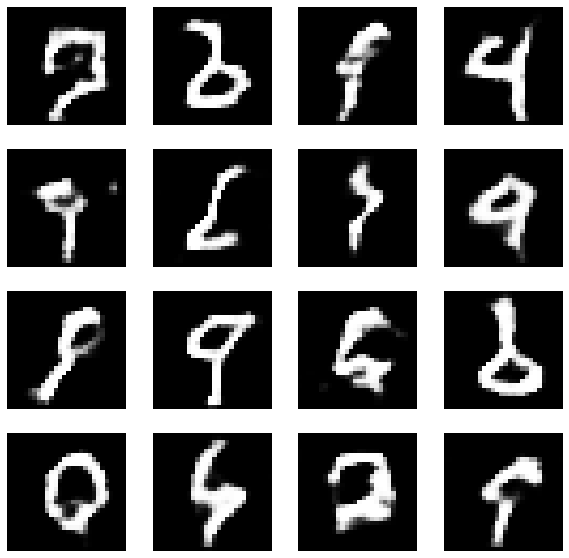

Epoch: 77


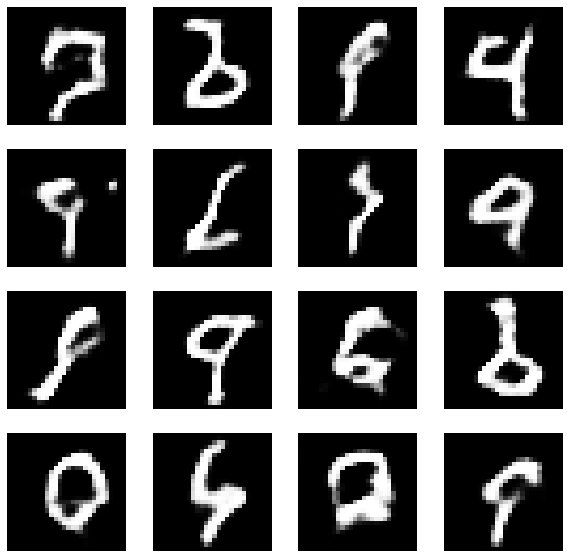

Epoch: 78


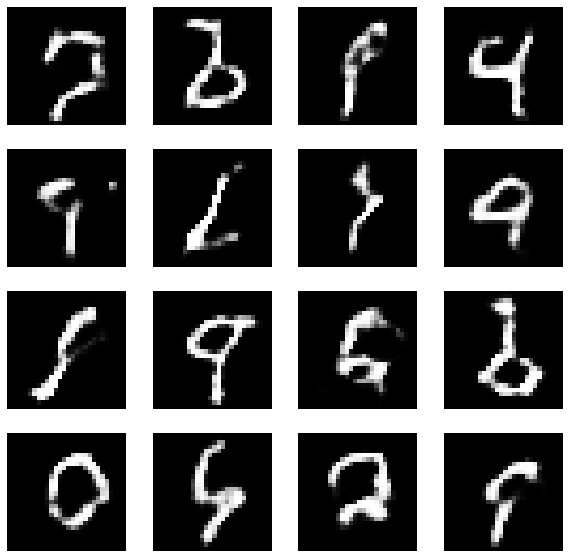

Epoch: 79


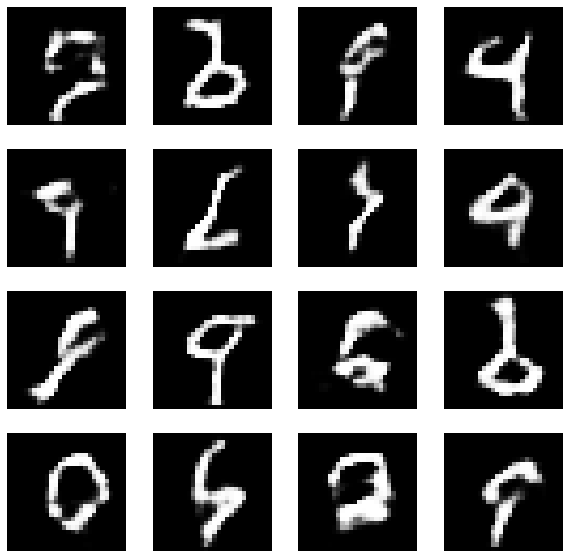

Epoch: 80


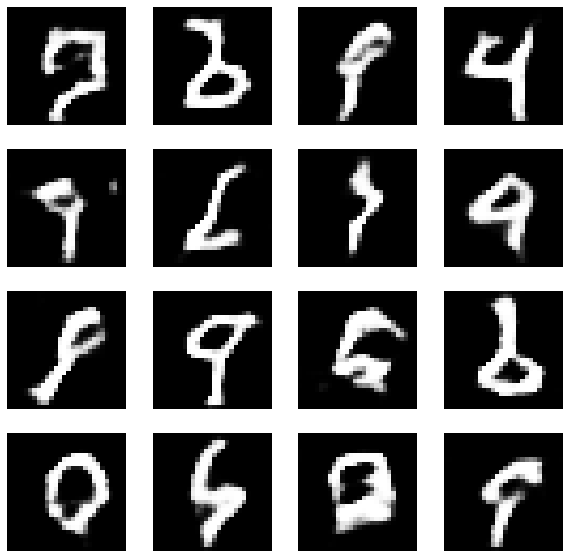

Epoch: 81


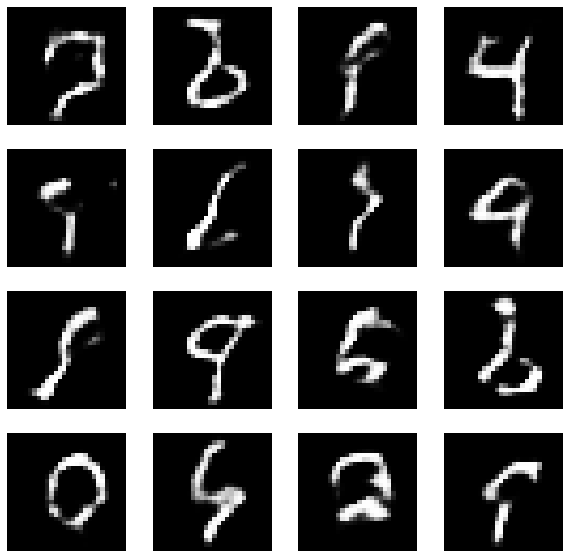

Epoch: 82


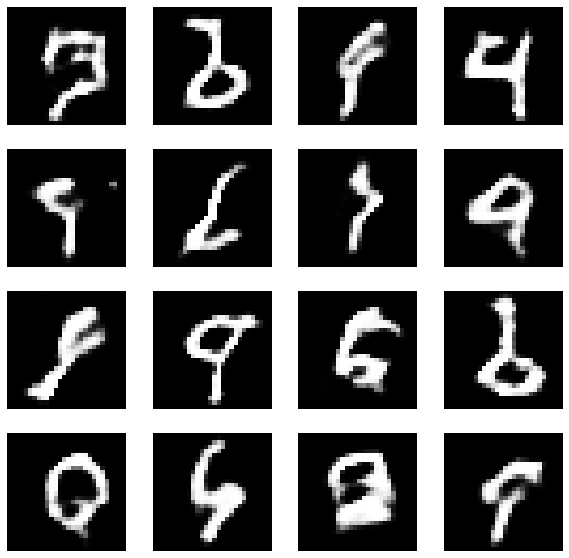

Epoch: 83


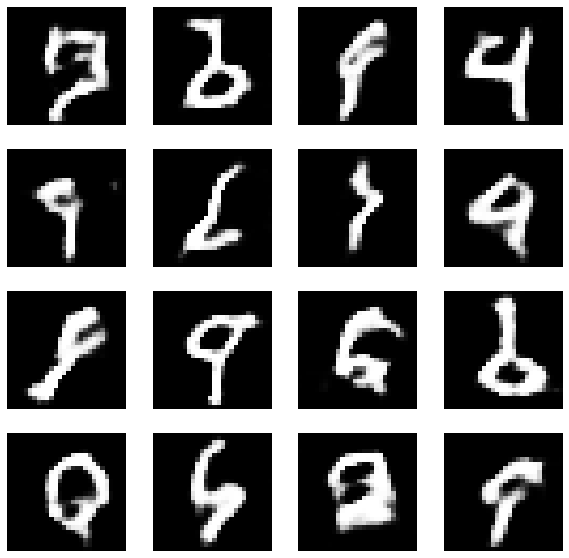

Epoch: 84


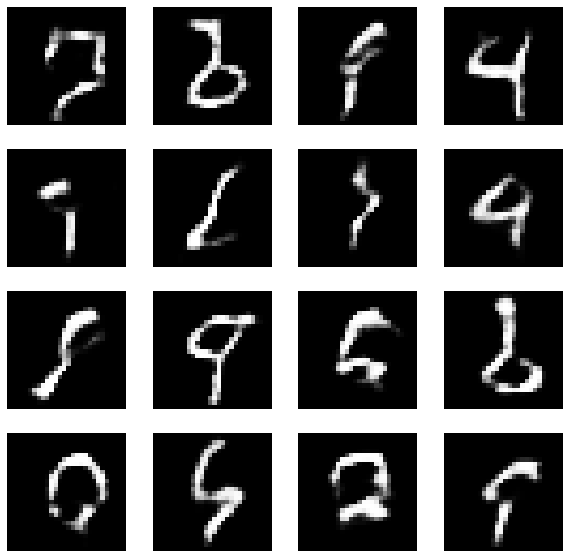

Epoch: 85


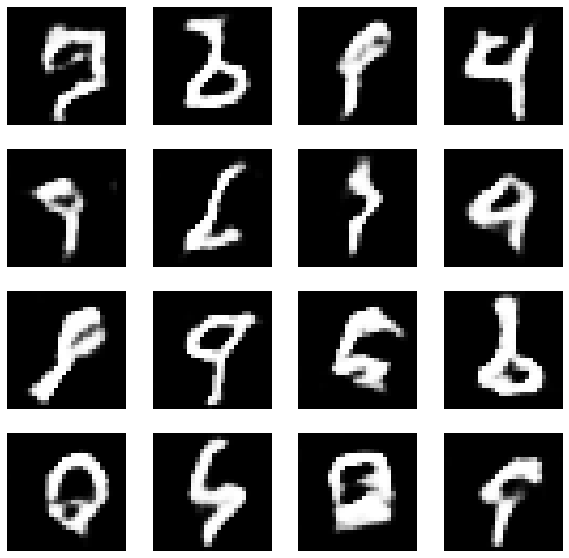

Epoch: 86


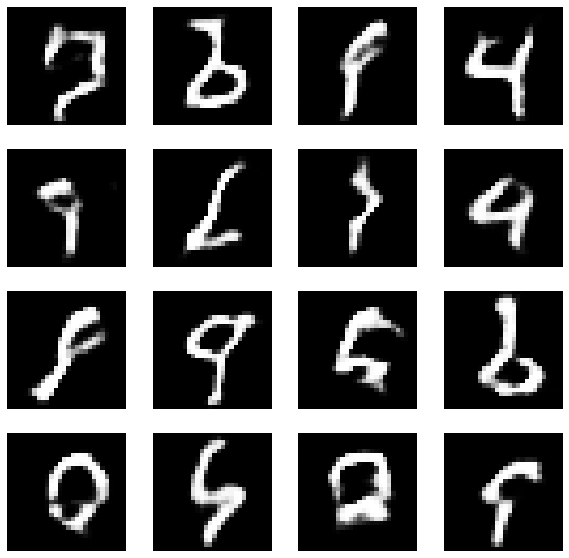

Epoch: 87


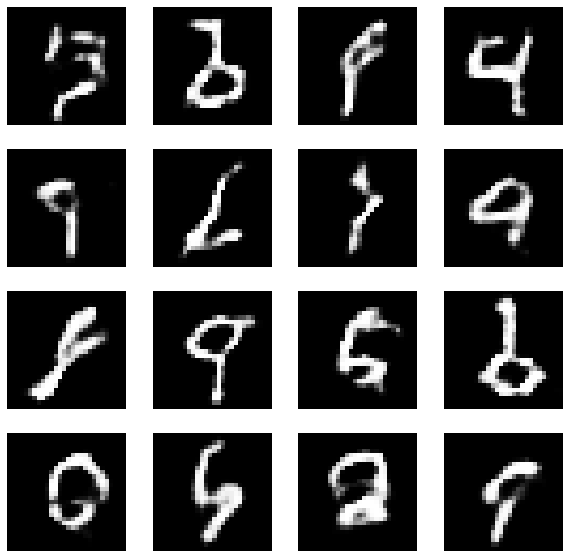

Epoch: 88


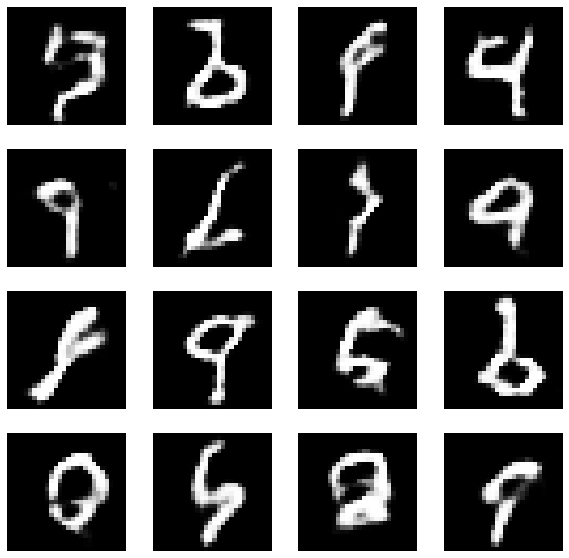

Epoch: 89


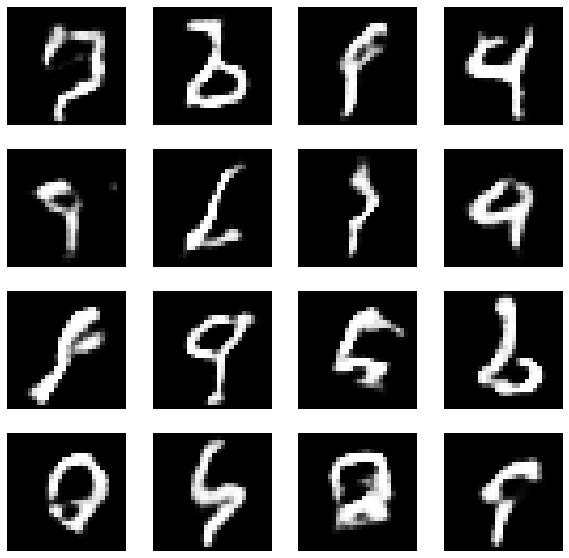

Epoch: 90


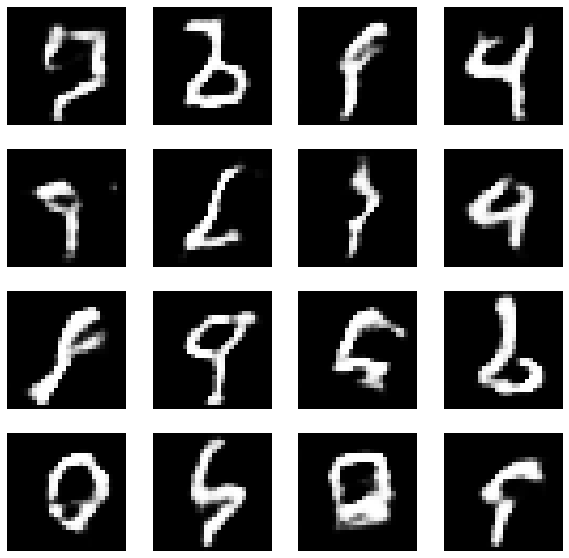

Epoch: 91


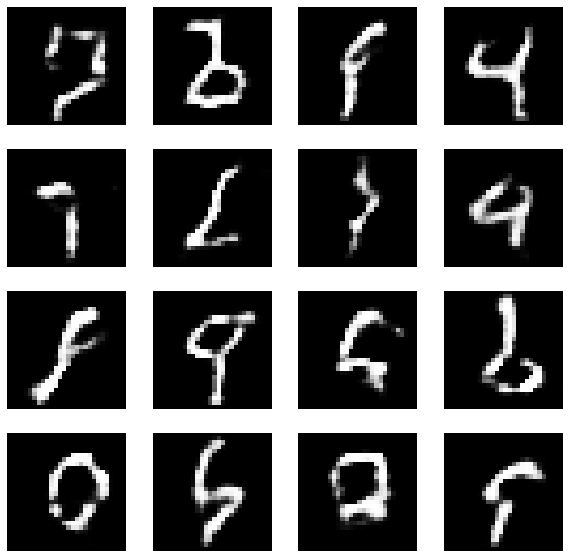

Epoch: 92


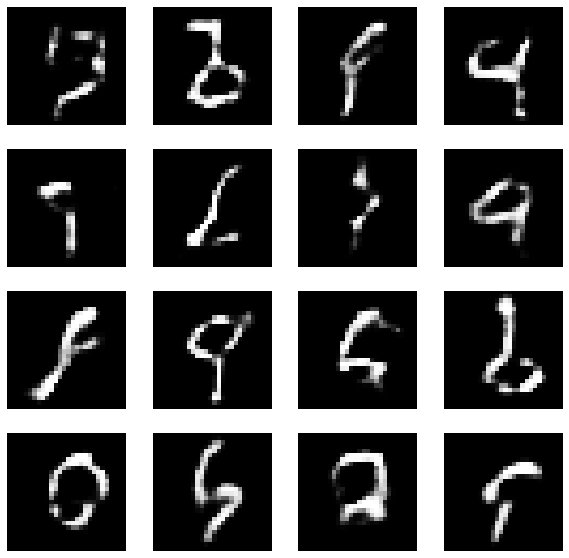

Epoch: 93


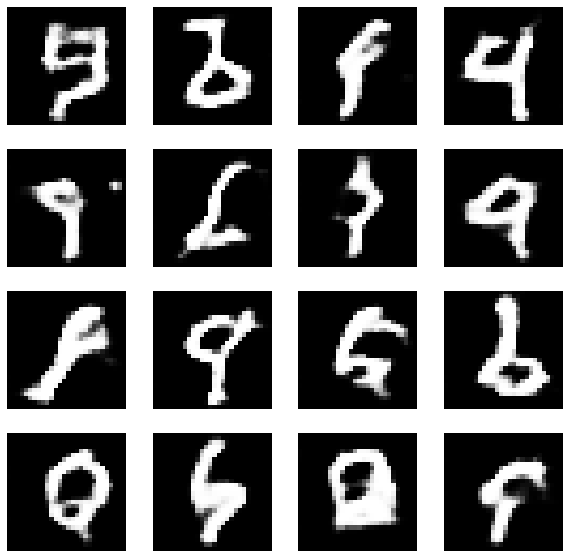

Epoch: 94


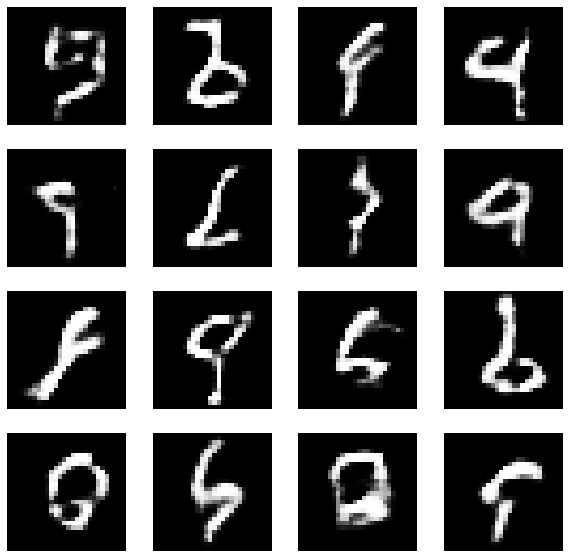

Epoch: 95


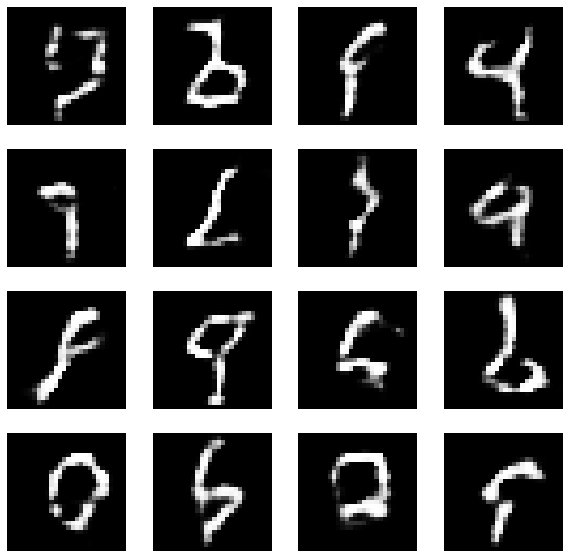

Epoch: 96


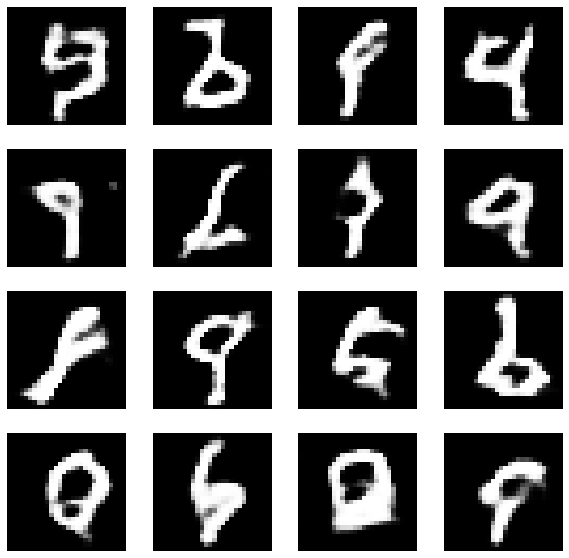

Epoch: 97


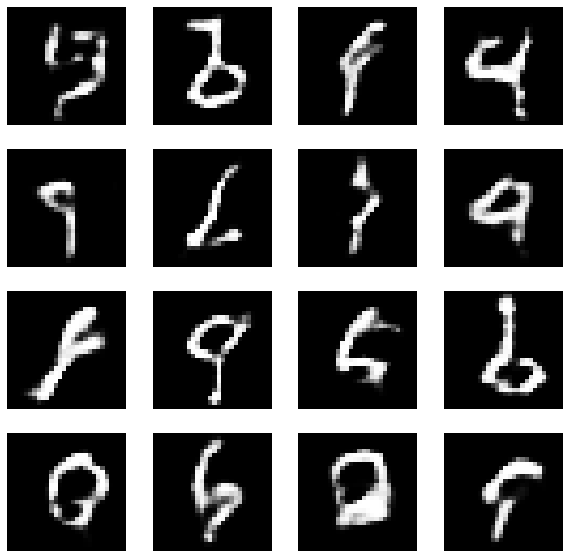

Epoch: 98


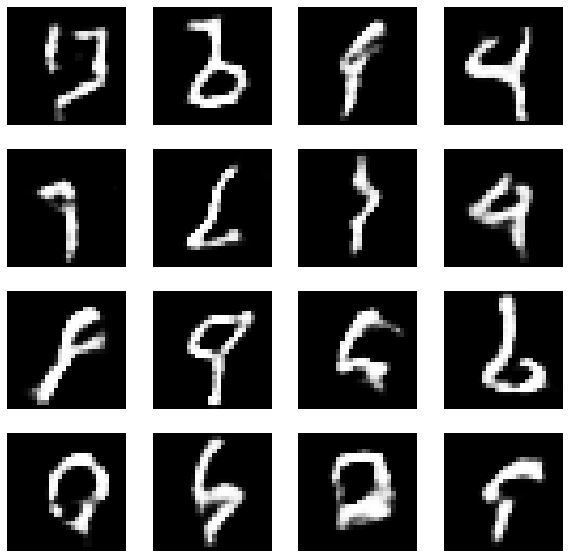

Epoch: 99


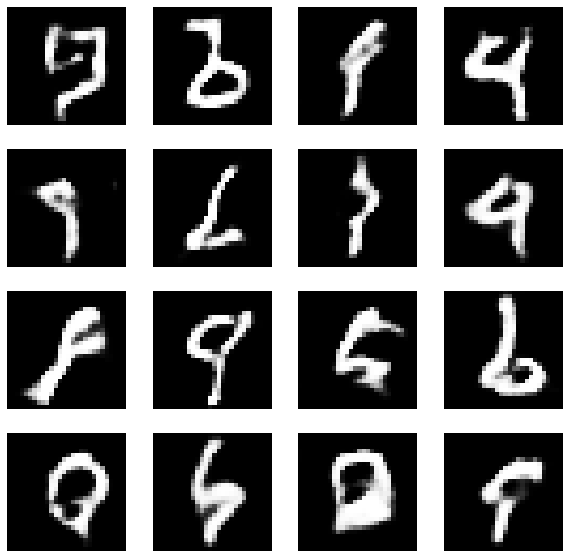

Epoch: 100


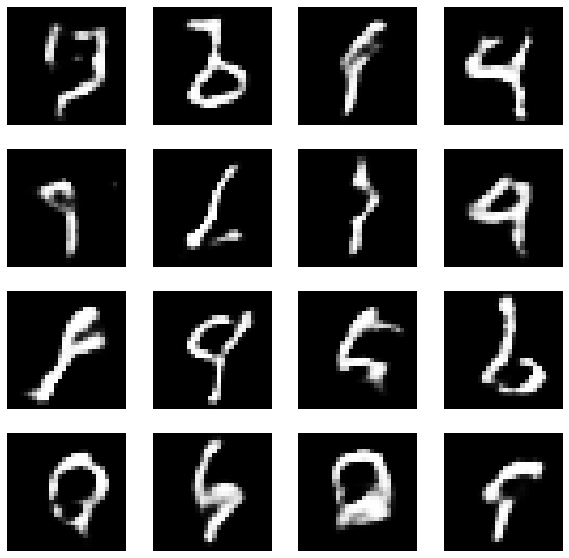

In [29]:
train_gan(x_train, epochs, test_images)